In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch.nn as nn
import torch
import torchvision.models as models
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
from torch.optim import lr_scheduler
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
import matplotlib.pyplot as plt
#tqdm
from tqdm import tqdm

In [2]:
from astra.torch.models import EfficientNet,ResNetClassifier, MLP, MLPClassifier, EfficientNetClassifier,EfficientNet_B0_Weights


In [3]:
train_model = EfficientNetClassifier(
    models.efficientnet_b0,EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
)



/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class Simclr_astra(nn.Module):
    def __init__(self, model, n_classes, featurizer=None, projection_head=None, dropout=0.1,in_features=None):
        super(Simclr_astra, self).__init__()
        self.base_model = train_model
        self.n_features = in_features

        self.base_model.classifier.classifier.in_features= in_features
        self.base_model.classifier.classifier = nn.Linear(in_features, in_features)
        self.base_model.classifier.classifier1 = nn.Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_head, bias=False),
            nn.BatchNorm1d(projection_head),
        )
    def forward(self, x_i, x_j):
        h_i = self.base_model(x_i)
        h_j = self.base_model(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [5]:
model=Simclr_astra(train_model, 2, featurizer=None, projection_head=128, dropout=0.1,in_features=512)
model

Simclr_astra(
  (base_model): EfficientNetClassifier(
    (featurizer): EfficientNet(
      (efficientnet): EfficientNet(
        (features): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): Sequential(
            (0): MBConv(
              (block): Sequential(
                (0): Conv2dNormActivation(
                  (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): SiLU(inplace=True)
                )
                (1): SqueezeExcitation(
                  (avgpool): AdaptiveAvgPool2d(output_size=1)
                  (fc1): Conv2d(32, 8, kernel_size=(1, 1), stri

In [6]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

In [7]:
index = loaded_data['index']
images1 = loaded_data['images']
labels1 = loaded_data['labels']
d_images1=images1[:5000]
d_labels1=labels1[:5000]
print(d_images1.shape)
print(d_labels1.shape)
image=loaded_data1['images']
label=loaded_data1['labels']
b_image1=image[:10000]
b_label1=label[:10000]
print(b_image1.shape)
print(b_label1.shape)

torch.Size([5000, 3, 224, 224])
torch.Size([5000])
torch.Size([10000, 3, 224, 224])
torch.Size([10000])


In [8]:
pretrain_images = torch.cat((b_image1, d_images1), dim=0)
pretrain_labels = torch.cat((b_label1, d_labels1), dim=0)
pretrain_image=pretrain_images/255
pretrain_image=(pretrain_image-pretrain_image.mean(dim=(0,2,3),keepdim=True))/pretrain_image.std(dim=(0,2,3),keepdim=True)

In [9]:
class Augment_train(object):
  def __init__(self,size):
    s = 0.5 # jitter strength
    # size = 224
    color_jitter = transforms.ColorJitter(0.4*s, 0.4*s, 0.4*s, 0.1*s)
    
    self.train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.5), 
        transforms.RandomGrayscale(p=0.4),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
  
  def __call__(self,x):
    transform = self.train_transforms

    xi = transform(x)
    xj = transform(x)
    return xi, xj

In [10]:
aumention = Augment_train(224)
augmented_images1,augmented_images2 = aumention(pretrain_image)

In [11]:
print(augmented_images1.shape)
print(augmented_images2.shape)

torch.Size([15000, 3, 224, 224])
torch.Size([15000, 3, 224, 224])


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

print(augmented_images1.shape)
print(augmented_images2.shape)
class CustomDataset(Dataset):
    def __init__(self, images1, images2):
        self.images1 = images1
        self.images2 = images2

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        return self.images1[idx], self.images2[idx]

custom_dataset = CustomDataset(augmented_images1, augmented_images2)
print(len(custom_dataset))
trainloader = DataLoader(custom_dataset, batch_size=256 ,shuffle=True, num_workers=16)

torch.Size([15000, 3, 224, 224])
torch.Size([15000, 3, 224, 224])
15000


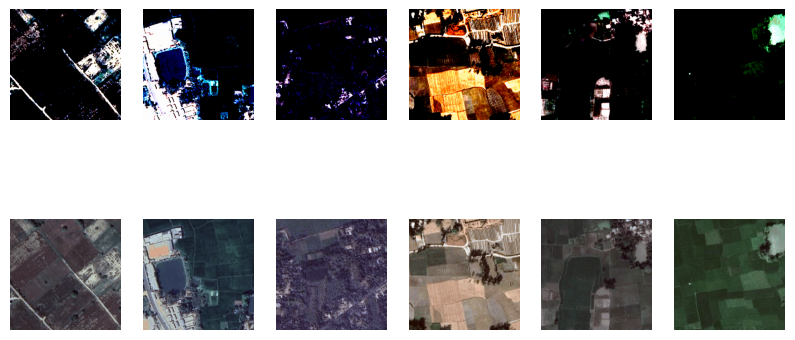

In [13]:
import matplotlib.pyplot as plt

# Get the first batch of images from the trainloader
for i, (batch_images1, batch_images2) in enumerate(trainloader):
    if i == 0:
        break

# Plot the images
fig, axes = plt.subplots(2, 6, figsize=(10, 5))
for i in range(6):
    # Plot images from batch_images1
    image1 = (batch_images1[i] - batch_images1[i].min()) / (batch_images1[i].max() - batch_images1[i].min())
    axes[0, i].imshow(image1.permute(1, 2, 0))
    axes[0, i].axis('off')

    # Plot images from batch_images2
    image2 = (batch_images2[i] - batch_images2[i].min()) / (batch_images2[i].max() - batch_images2[i].min())
    axes[1, i].imshow(image2.permute(1, 2, 0))
    axes[1, i].axis('off')

plt.show()

In [14]:
class NTXent_L(nn.Module):
  def __init__(self,batch_size,temperature=0.5):
      super().__init__()
      self.batch_size=batch_size
      self.temperature = temperature
      
  def cosine_sim(self, output1,output2): #output1, output2 as 2 augmented versions of image;
    o_con= torch.cat([output1,output2], dim=0)
    return F.cosine_similarity(o_con.unsqueeze(1), o_con.unsqueeze(0), dim=2)
  def forward(self, z_i, z_j):

    batch_size= z_i.shape[0]

    sim_m = self.cosine_sim(z_i,z_j)

    sim_ij = torch.diag(sim_m,batch_size)
    sim_ji = torch.diag(sim_m, -batch_size)
   
    sim_con= torch.cat([sim_ij, sim_ji],dim=0)
    pos= torch.exp(sim_con/self.temperature)
    mask = (~torch.eye(batch_size *2 ,batch_size*2, dtype=bool)).float()
    neg= mask.to(device) *torch.exp(sim_m/self.temperature)
    loss = torch.sum(-torch.log(pos/torch.sum(neg, dim=1))) / (2*self.batch_size)
    
    return loss

In [15]:
criterion = NTXent_L(batch_size=256, temperature = 0.5)
criterion = criterion.to(device)

In [16]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.3)
# lr=0.3


In [17]:
train_losses = []
def train(epoch):
    model.train()
    s = 0
    tot_loss = 0
    total = 0
    batch_idx = 0
    i = 0
    for batch_idx, (images) in enumerate(trainloader):
        images[0], images[1] = images[0].to(device), images[1].to(device)
        optimizer.zero_grad()

        h_i, h_j, z_i, z_j = model(images[0], images[1])
        loss = criterion(z_i, z_j)

        loss.backward()

        optimizer.step()

        tot_loss += loss.item()

    # print("epoch=", epoch)
    # print("epoch loss=", tot_loss)
    train_losses.append(tot_loss)

    if epoch % 10 == 0:
        modelstate_save_name = 'modelstate_simclr_astra_bk_DB_15000.pt'
        path_modelstate = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{modelstate_save_name}"
        torch.save(model.state_dict(), path_modelstate)

        parameters_end = {
            'net': model.state_dict(),
            'epoch': epoch,
            'loss': tot_loss
        }
        paramsend_save_name = 'paramsend__simclr_astra_bk_DB_15000.pt'
        path_paramsend = F"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/{paramsend_save_name}"
        torch.save(parameters_end, path_paramsend)
        print("epoch=", epoch)
        print("epoch loss=", tot_loss)

start_epoch = 0
for epoch in tqdm(range(start_epoch, start_epoch + 301)):
    train(epoch)

  0%|          | 1/301 [00:52<4:20:56, 52.19s/it]

epoch= 0
epoch loss= 293.64478826522827


  4%|▎         | 11/301 [09:14<4:05:48, 50.86s/it]

epoch= 10
epoch loss= 254.09206986427307


  7%|▋         | 21/301 [17:34<3:53:26, 50.02s/it]

epoch= 20
epoch loss= 252.34757709503174


 10%|█         | 31/301 [25:50<3:43:12, 49.60s/it]

epoch= 30
epoch loss= 251.64815425872803


 14%|█▎        | 41/301 [34:07<3:35:49, 49.81s/it]

epoch= 40
epoch loss= 251.32968711853027


 17%|█▋        | 51/301 [42:25<3:28:12, 49.97s/it]

epoch= 50
epoch loss= 251.18180894851685


 20%|██        | 61/301 [50:45<3:19:16, 49.82s/it]

epoch= 60
epoch loss= 250.93266201019287


 24%|██▎       | 71/301 [59:01<3:10:18, 49.65s/it]

epoch= 70
epoch loss= 250.9331226348877


 27%|██▋       | 81/301 [1:07:11<2:57:41, 48.46s/it]

epoch= 80
epoch loss= 250.77362203598022


 30%|███       | 91/301 [1:15:10<2:48:08, 48.04s/it]

epoch= 90
epoch loss= 250.67969918251038


 34%|███▎      | 101/301 [1:23:18<2:43:29, 49.05s/it]

epoch= 100
epoch loss= 250.60474467277527


 37%|███▋      | 111/301 [1:31:28<2:35:14, 49.02s/it]

epoch= 110
epoch loss= 250.63177251815796


 40%|████      | 121/301 [1:39:38<2:26:52, 48.96s/it]

epoch= 120
epoch loss= 250.55937838554382


 44%|████▎     | 131/301 [1:47:48<2:19:06, 49.10s/it]

epoch= 130
epoch loss= 250.46663236618042


 47%|████▋     | 141/301 [1:56:05<2:13:11, 49.95s/it]

epoch= 140
epoch loss= 250.42435145378113


 50%|█████     | 151/301 [2:04:21<2:04:11, 49.68s/it]

epoch= 150
epoch loss= 250.41942644119263


 53%|█████▎    | 161/301 [2:12:37<1:55:45, 49.61s/it]

epoch= 160
epoch loss= 250.46790838241577


 57%|█████▋    | 171/301 [2:20:49<1:46:43, 49.26s/it]

epoch= 170
epoch loss= 250.31313943862915


 60%|██████    | 181/301 [2:29:02<1:38:40, 49.34s/it]

epoch= 180
epoch loss= 250.28129053115845


 63%|██████▎   | 191/301 [2:37:13<1:30:00, 49.09s/it]

epoch= 190
epoch loss= 250.28792190551758


 67%|██████▋   | 201/301 [2:45:25<1:22:15, 49.36s/it]

epoch= 200
epoch loss= 250.25486159324646


 70%|███████   | 211/301 [2:53:40<1:14:01, 49.35s/it]

epoch= 210
epoch loss= 250.18731689453125


 73%|███████▎  | 221/301 [3:01:54<1:05:57, 49.47s/it]

epoch= 220
epoch loss= 250.15353059768677


 77%|███████▋  | 231/301 [3:10:07<57:29, 49.28s/it]  

epoch= 230
epoch loss= 250.15219902992249


 80%|████████  | 241/301 [3:18:23<49:42, 49.70s/it]

epoch= 240
epoch loss= 250.12698483467102


 83%|████████▎ | 251/301 [3:26:36<41:03, 49.27s/it]

epoch= 250
epoch loss= 250.0899453163147


 87%|████████▋ | 261/301 [3:34:47<32:47, 49.20s/it]

epoch= 260
epoch loss= 250.07457637786865


 90%|█████████ | 271/301 [3:42:59<24:36, 49.23s/it]

epoch= 270
epoch loss= 250.04581785202026


 93%|█████████▎| 281/301 [3:51:10<16:20, 49.04s/it]

epoch= 280
epoch loss= 250.0521969795227


 97%|█████████▋| 291/301 [3:59:18<08:10, 49.09s/it]

epoch= 290
epoch loss= 250.00809454917908


100%|██████████| 301/301 [4:07:36<00:00, 49.36s/it]

epoch= 300
epoch loss= 250.01158380508423


: 